In [4]:
import pandas as pd
from pprint import pprint
import numpy as np
import ollama
import matplotlib.pyplot as plt
from evaluate import load
import math


/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
LLM = "mistral_largest_latest"

PATH_TO_RESULTS = f"results/results_{LLM}.csv" 
PATH_TO_PLOTS = f"results/{LLM}/"

In [7]:
results = pd.read_csv(PATH_TO_RESULTS, sep=';')
print(results.head())

# count nan in columns
print("llm0: ", results['llm0'].isna().sum())
print("llm1: ", results['llm1'].isna().sum())
print("llm2: ", results['llm2'].isna().sum())
print("llm3: ", results['llm3'].isna().sum())
print("expert_answer: ", results['expert_answer'].isna().sum())

# replace nan with empty string
results= results.fillna('')

   Unnamed: 0  conversation_id  \
0           0         15137761   
1           1         15104383   
2           2         15059877   
3           3         15140315   
4           4         15146691   

                                       user_question  \
0  Seit 3 Tagen Behandlung eines Ekzem am Hals mi...   
1  Chronische Nierenschwäche (zu viel Eiweiß und ...   
2  Sehr geehrter Dr. Stehn, ich habe seid 7 Woche...   
3  Hallo Zusammen, Vor 3 Jahren OV mit einer Frau...   
4  Guten Tag, Ich hatte vor ca. 1 1/2 Monaten Cor...   

                                       expert_answer  \
0  Hallo,\nsollte eine Therapie nicht anschlagen,...   
1  Hallo\n,\nLeider dürfen wir ohne\nUntersuchung...   
2  Sehr geehrte Ringelblume,\ngrundsätzlich gilt ...   
3  Hallo,\nin der Tat sind\nChlamydien\nund\nMyko...   
4  Hallo,\nin der Regel heilt das Trommelfell wie...   

                                        user_context  \
0  Seit 3 Tagen Behandlung eines Ekzem am Hals mi...   
1  Chroni

In [8]:
def get_bert_scores(column_name):
    bertscore = load("bertscore")
    predictions = results[column_name].values
    references = results['expert_answer'].values
    scores = bertscore.compute(predictions=predictions, references=references, lang="de")
    return scores

In [9]:
bert_scores_llm0 = get_bert_scores('llm0')
bert_scores_llm1 = get_bert_scores('llm1')
bert_scores_llm2 = get_bert_scores('llm2')
bert_scores_llm3 = get_bert_scores('llm3')

In [10]:
bert_f1_llm0 = np.array(bert_scores_llm0['f1'])
bert_f1_llm1 = np.array(bert_scores_llm1['f1'])
bert_f1_llm2 = np.array(bert_scores_llm2['f1'])
bert_f1_llm3 = np.array(bert_scores_llm3['f1'])

bert_f1 = [bert_f1_llm0, bert_f1_llm1, bert_f1_llm2, bert_f1_llm3]


In [101]:
def boxplot_scores(measures, labels, xlabel="", ylabel="", title="", filename=None):
    # boxplot rouge 1 scores
    plt.boxplot(measures)
    plt.xticks(np.arange(1, len(measures)+1), labels, rotation=45)
    # label mean values
    for i, measure in enumerate(measures):
        plt.text(i+1, np.mean(measure), str(round(np.mean(measure), 3)), color='blue')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

def lineplots_scores(measures, labels, xlabel="", ylabel="", title="", filename=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 15))
    
    for i, measure in enumerate(measures):
        if i == 0:
            ax[math.floor(i/2), i%2].plot(np.arange(len(measure)), measures[0], label=labels[0])
            continue
        ax[math.floor(i/2), i%2].plot(np.arange(len(measure)), measures[0], label=labels[0])
        ax[math.floor(i/2), i%2].plot(np.arange(len(measure)), measure, label=labels[i])
        ax[math.floor(i/2), i%2].legend()
        ax[math.floor(i/2), i%2].set_ylabel(ylabel)
        ax[math.floor(i/2), i%2].set_xlabel(xlabel)
    fig.suptitle(title)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

def scatterplots_scores(measures, labels, xlabel="", ylabel="", title="", filename=None):
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 3))
    
    for i, measure in enumerate(measures):
        if i == 0:
            continue
        ax[i-1].plot(np.arange(len(measure)), measures[0], label=labels[0], color='#008DD5', marker='+')
        ax[i-1].plot(np.arange(len(measure)), measure, label=labels[i], color='#5EF38C', marker='o')
        ax[i-1].legend()
        ax[i-1].set_ylabel(ylabel)
        ax[i-1].set_xlabel(xlabel)
    fig.suptitle(title)

def difference_plot(measures, labels, xlabel="", ylabel="", title="", filename=None):
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14, 3))
    for i in range(1, len(measures)):
        diff = measures[i] - measures[0]
        ax[i-1].plot(np.arange(len(diff)), np.sort(diff), color='#008DD5')
        ax[i-1].plot(np.arange(len(diff)), np.zeros(len(diff)), color='darkblue')
        # plot area between 0 and diff
        ax[i-1].fill_between(np.arange(len(diff)), np.sort(diff), interpolate=True, color='#008DD5', alpha=0.5)
        # plot vertical line where diff is 0
        x_vert = np.where(np.sort(diff) > 0)[0][0]
        ax[i-1].axvline(x=x_vert, color='red', linestyle='--')
        # add text to vertical line displaying the x value
        ax[i-1].text(x_vert + 0.1,0.01, f"{str(x_vert)}", color='red')
        ax[i-1].set_ylabel(ylabel)
        ax[i-1].set_xlabel(f"samples sorted by \n ({labels[i]} - {labels[0]})")
    fig.suptitle(title)
    if filename:
        fig.savefig(filename, bbox_inches='tight')

## Plot F1 Scores for different experimental setups
### Bert

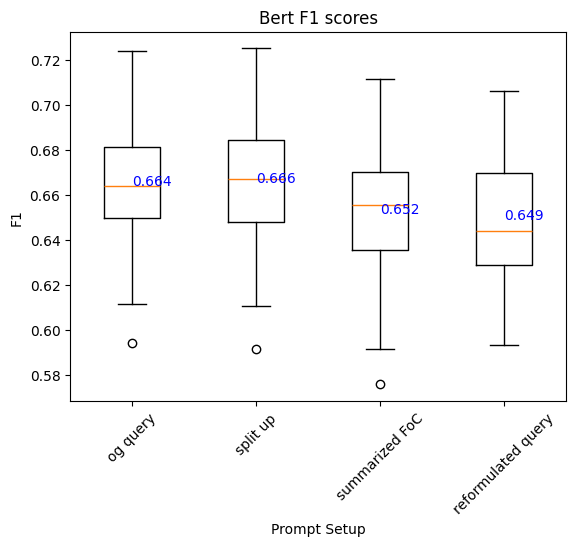

In [16]:
# boxplot rouge 1 scores
labels = ['og query', 'split up', 'summarized FoC', 'reformulated query']

boxplot_scores(bert_f1, labels, 'Prompt Setup', 'F1', 'Bert F1 scores', f'{PATH_TO_PLOTS}bert_f1.png')

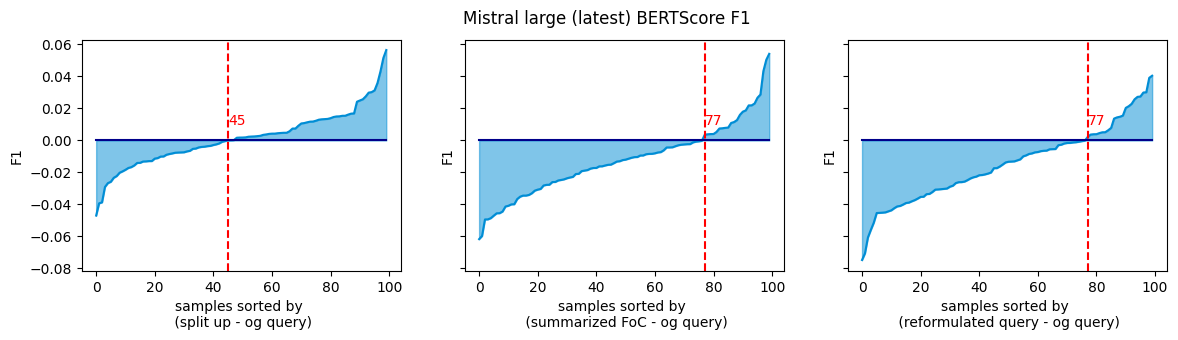

In [103]:
difference_plot(bert_f1, labels, 'Sample', 'F1', 'Mistral large (latest) BERTScore F1', f'{PATH_TO_PLOTS}bert_f1_line.pdf')

In [105]:
# get sample with max difference 
sample_split_up = np.argmax(bert_f1[1] - bert_f1[0])
sample_summarized = np.argmax(bert_f1[2] - bert_f1[0])
sample_reformulated = np.argmax(bert_f1[3] - bert_f1[0])
print(sample_split_up, sample_summarized, sample_reformulated)  

69 8 81


In [3]:
lineplots_scores(bert_f1, labels, 'Sample','F1', 'Comparing Bert F1 scores by sample', f'{PATH_TO_PLOTS}bert_f1_scatter.pdf')

NameError: name 'bert_f1' is not defined

### Precision

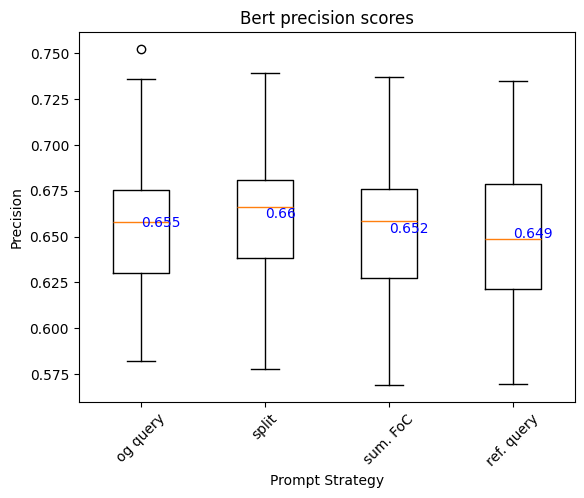

In [10]:
# boxplot rouge 1 scores
bert_precision = [np.array(bert_scores_llm0['precision']), np.array(bert_scores_llm1['precision']), np.array(bert_scores_llm2['precision']), np.array(bert_scores_llm3['precision'])]
labels = ['og query', 'split', 'sum. FoC', 'ref. query']

boxplot_scores(bert_precision, labels, 'Prompt Strategy', 'Precision', 'Bert precision scores', f'{PATH_TO_PLOTS}bert_precision.png')

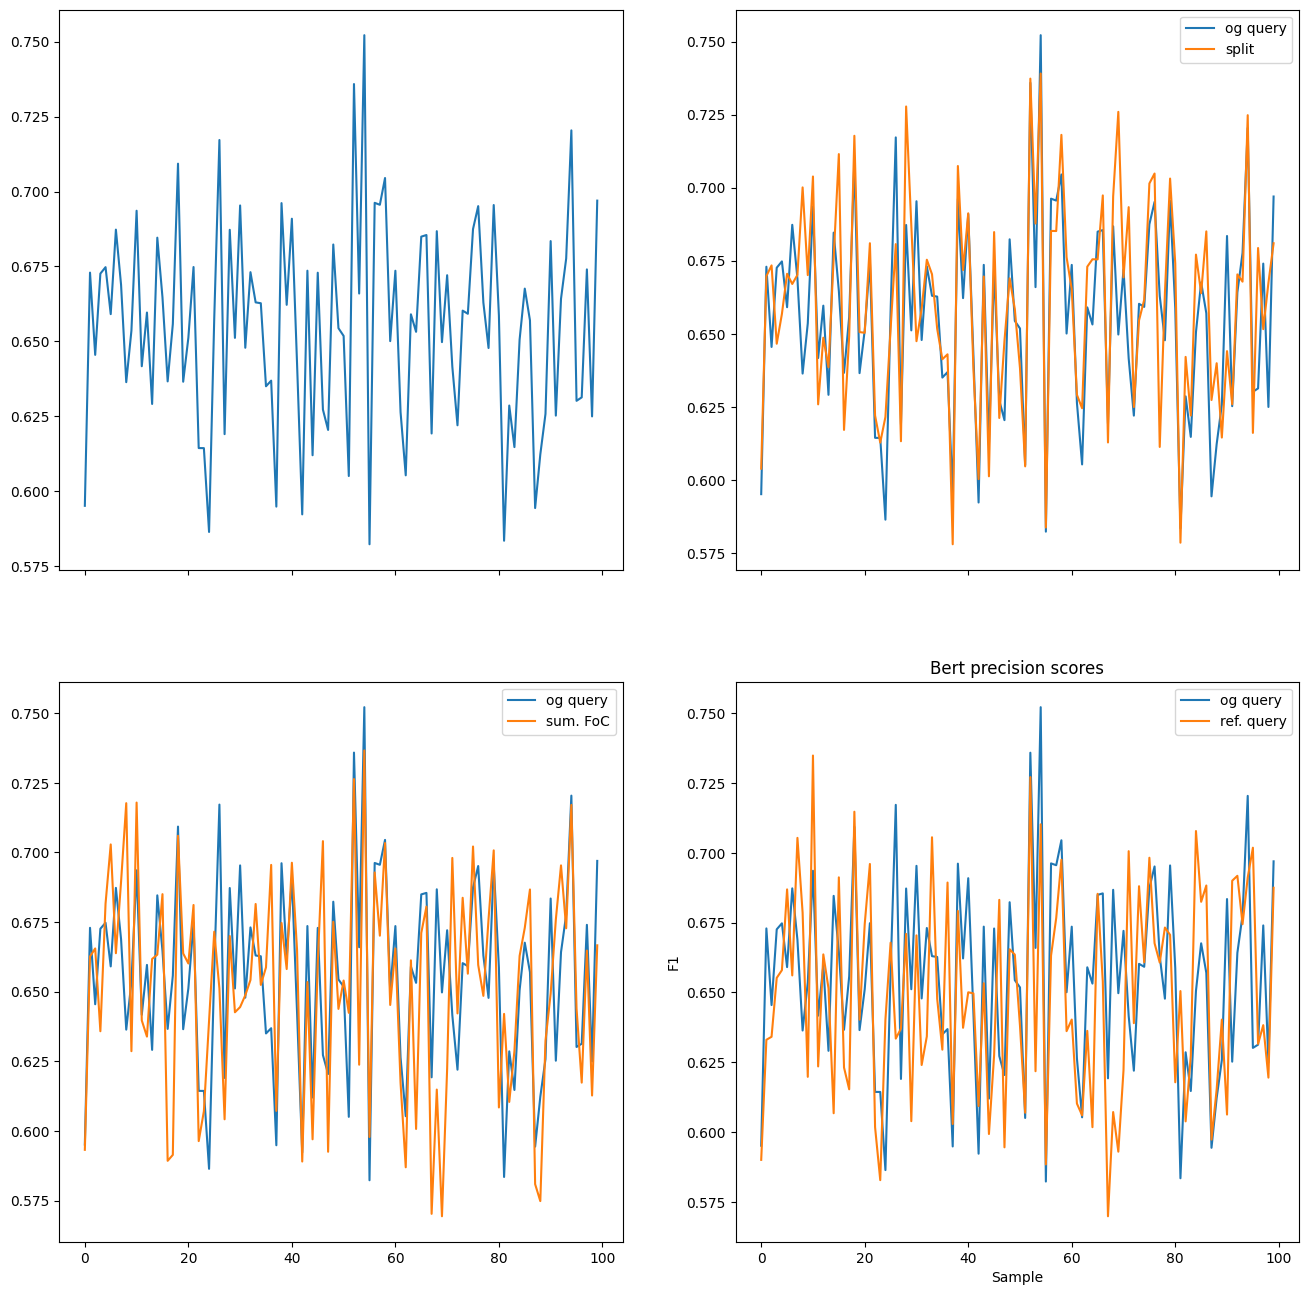

In [11]:
lineplots_scores(bert_precision, labels, 'Sample', 'F1', 'Bert precision scores', f'{PATH_TO_PLOTS}bert_precision_line.png')

### Rouge-L

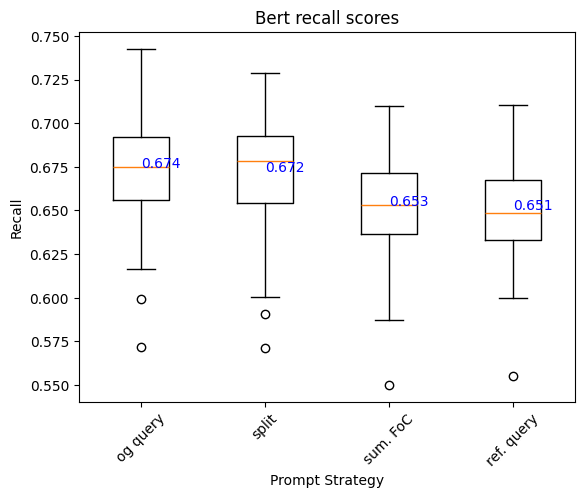

In [12]:
# boxplot Rouge L scores
bert_recall = [np.array(bert_scores_llm0['recall']), np.array(bert_scores_llm1['recall']), np.array(bert_scores_llm2['recall']), np.array(bert_scores_llm3['recall'])]
labels = ['og query', 'split', 'sum. FoC', 'ref. query']

boxplot_scores(bert_recall, labels, 'Prompt Strategy', 'Recall', 'Bert recall scores', f'{PATH_TO_PLOTS}bert_recall.png')

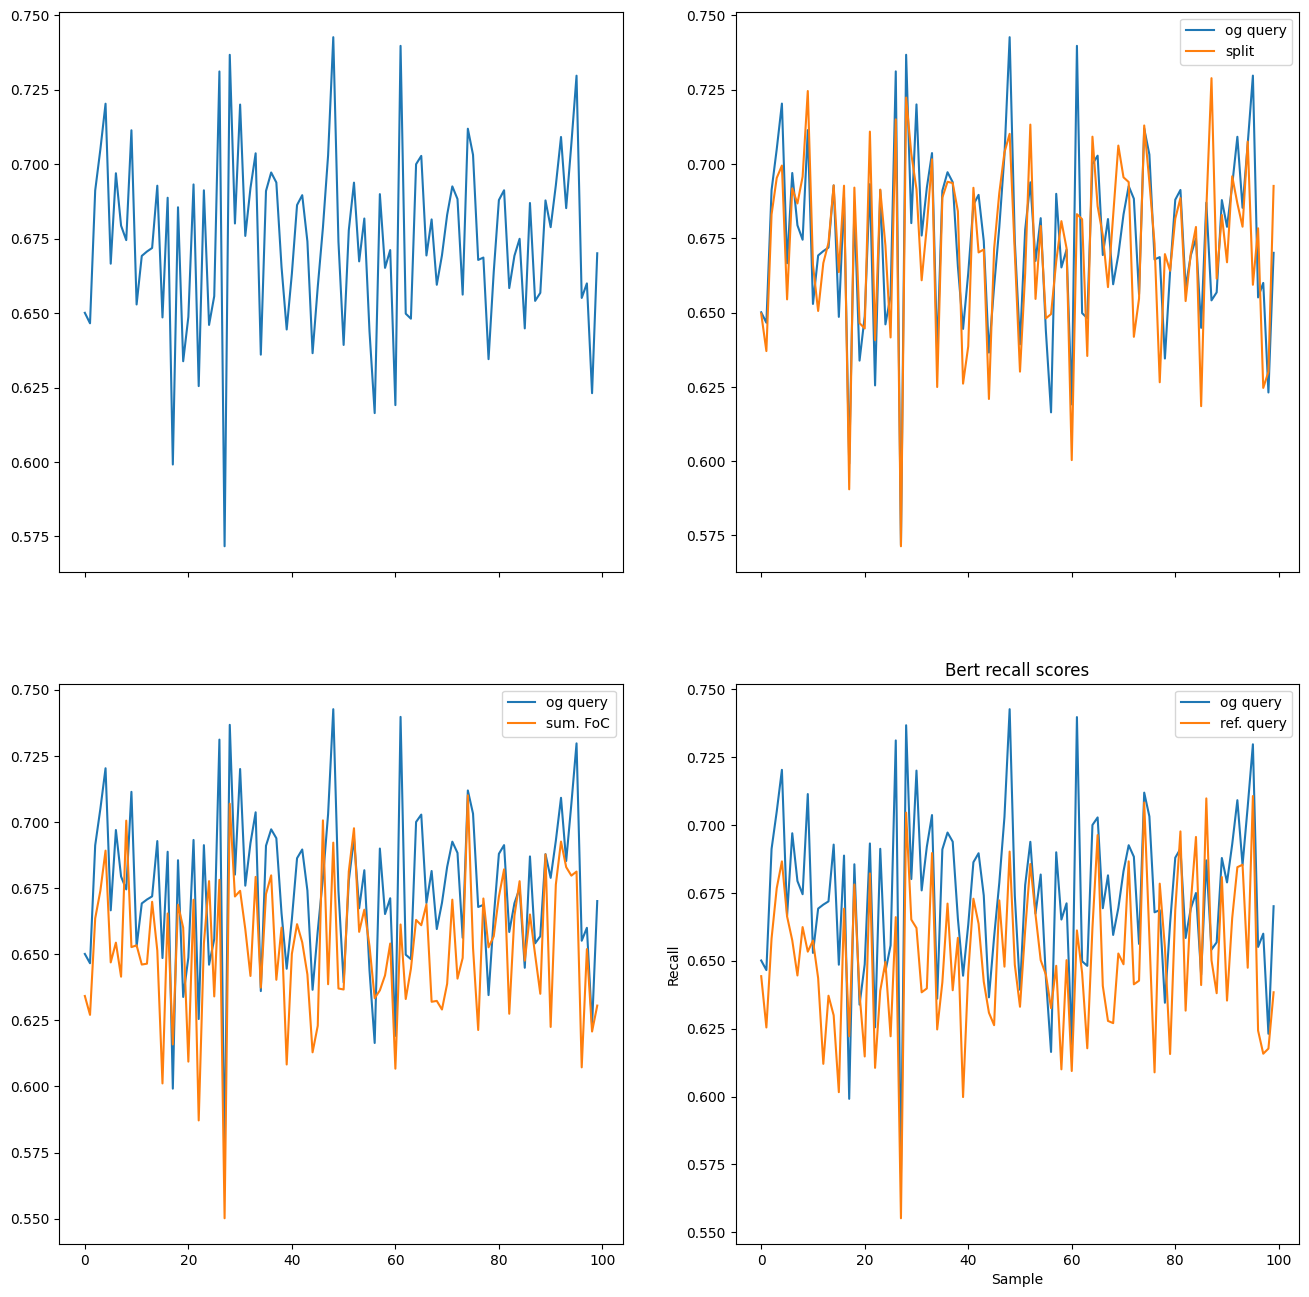

In [13]:
lineplots_scores(bert_recall, labels, 'Sample', 'Recall', 'Bert recall scores', f'{PATH_TO_PLOTS}bert_recall_lines.png')